In [1]:
import os
# os.chdir("../")
# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

from config import *
from data import *
from train import *
from eval import *
from generation import *
from vital2d import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [2]:
# (customize) configs
overwrite = True
model_name = 'tmp' 
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    # txt2ts
    txt2ts_y_cols = ['description_succ_inc'],
    
    
    # Data settings
    text_col = 'description_succ_inc', #'ts_description',
    downsample = True,
    downsample_size = 500,
    downsample_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    custom_target_cols = ['description_succ_inc', 'label'], # 'label' is the same as the default "by_label" target
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = False,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 200,
    alpha = 1/10,
    num_saves = 1,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()


# Data

In [3]:
# run preprocess.py to ready the data
with open('run_preprocess.py', 'r') as file:
    exec(file.read())



Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.7s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    5.3s
[Parallel(n_jobs=9)]: Done 62548 tasks      | elapsed:   13.7s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   14.0s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    42910
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.0s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    7.4s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    7.5s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    36173
Low amount of consecutive increases.         13165
High amount of consecutive increases.        11859
Name: count, dtype: int64
After downsampling:
description_succ_inc
High amount of consecutive increases.    500
Low amount of consecutive increases.     500
Name: count, dtype: int64
After downsampling:
description_succ_inc
High amount of consecutive increases.    500
Low amount of consecutive increases.     500
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
High amount of consecutive increases.    500
Low amount of consecutive increases.     500
Name: count, dtype: int64
description_succ_inc
High amount of consecutive increases.    500
Low amount of consecutive increases.     500
Name: count, dtype: int64


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Model (customizable)

In [4]:
# customize encoder and decoder here. 
ts_encoder = CNNEncoder(ts_dim = ts_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[4], kernel_size=50, dropout=0)
ts_decoder = None # default decoder
text_encoder = TextEncoderCNN(text_dim = tx_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[4], kernel_size=50, dropout=0)
# overwrite = False
with open('run_model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                   Param #
VITAL                                    1
├─TSVAEEncoder: 1-1                      --
│    └─LocalNorm: 2-1                    --
│    └─CNNEncoder: 2-2                   --
│    │    └─Sequential: 3-1              307,924
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
├─TextEncoder: 1-2                       --
│    └─TextEncoderCNN: 2-5               --
│    │    └─Sequential: 3-2              787,156
├─TSVAEDecoder: 1-3                      --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-3                  131,328
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  65,792
│    │    └─LeakyReLU: 3-6               --
│    │    └─Linear: 3-7                  77,100
Total params: 1,894,613
Trainable params: 1,894,613
Non-trainable params: 0


# Train

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500]
	Training Loss: 3149.879028 (clip: 814.608276, vae: 23352.706055)
	Testing Loss: 4715.301270 (clip: 1980.943115, vae: 27343.582031)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [11/500]
	Training Loss: 3105.381836 (clip: 795.807495, vae: 23095.743164)
	Testing Loss: 2774.185059 (clip: 799.680908, vae: 19745.041016)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [21/500]
	Training Loss: 3084.925415 (clip: 779.870483, vae: 23050.548828)
	Testing Loss: 2756.482910 (clip: 784.274078, vae: 19722.088867)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [31/500]
	Training Loss: 3050.721558 (clip: 760.909729, vae: 22898.117188)
	Testing Loss: 2725.881104 (clip: 761.565887, vae: 19643.151367)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [41/500]
	Training Loss: 3026.826904 (clip: 743.487640, vae: 22833.392578)
	Testing Loss: 2705.465088 (clip: 746.867676, vae: 19585.973633)
	Learning Rate: 0.000100000
beta: 0.0
Epoch [51/500]
	Training Loss: 3011.687256 (clip: 742.943634, vae: 22687.435547)

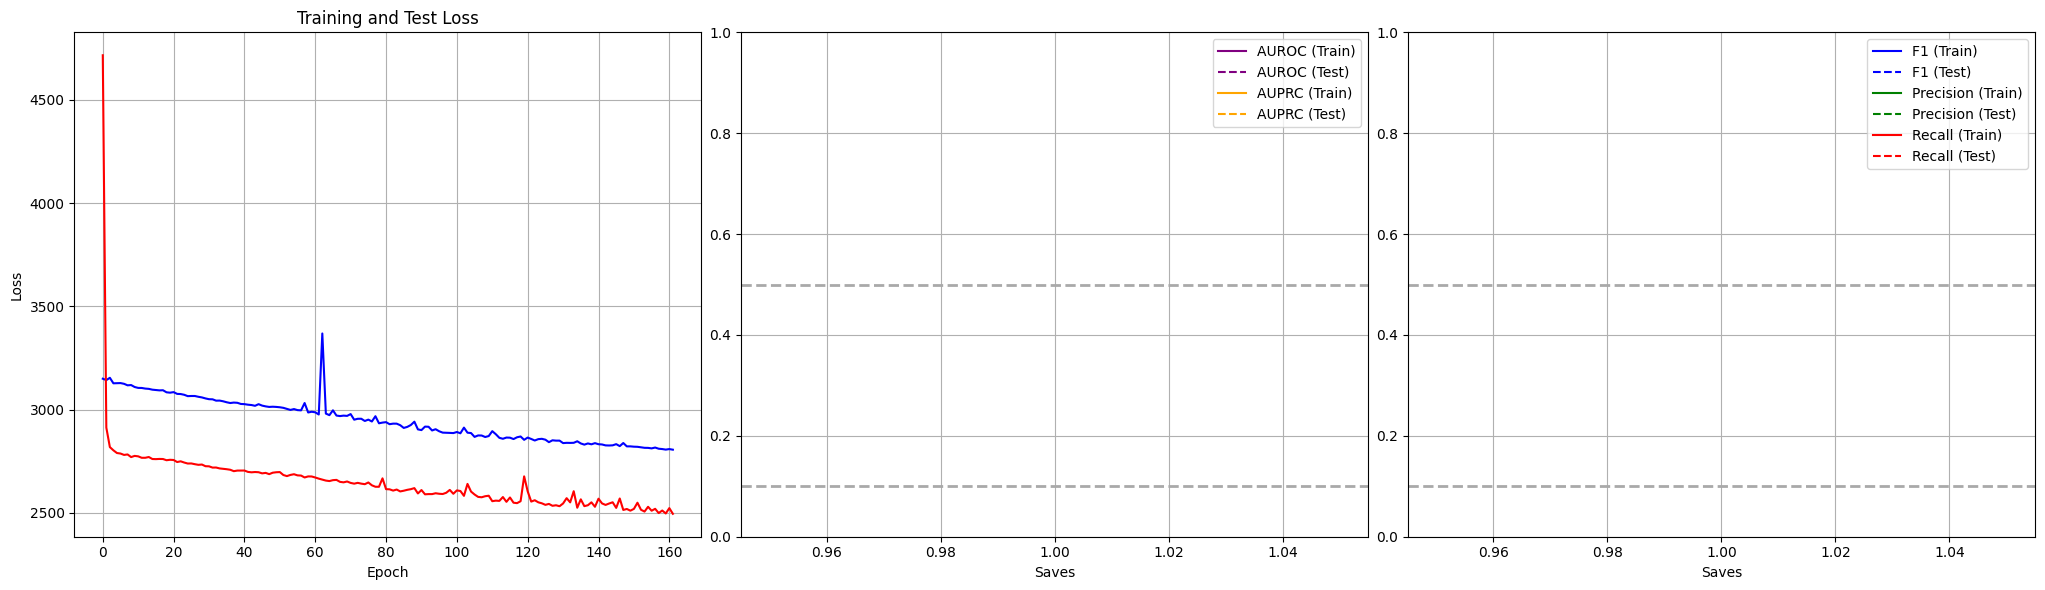

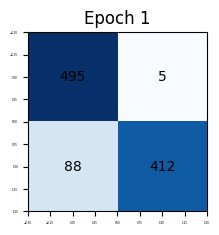

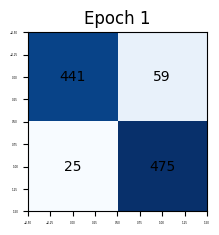

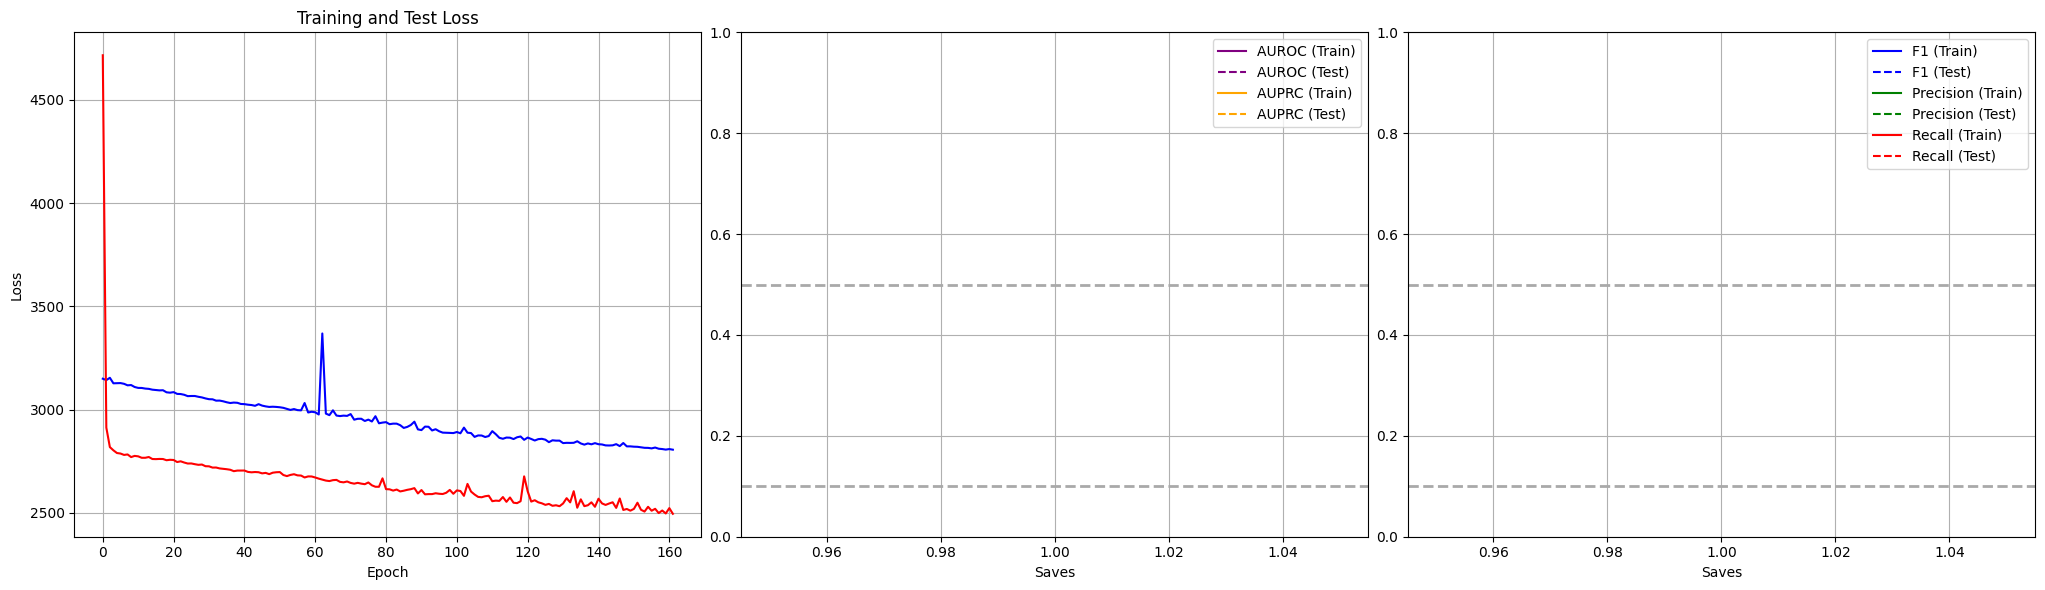

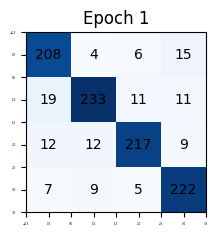

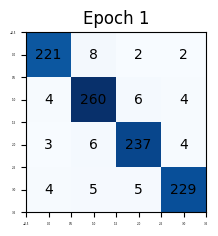

In [ ]:
# overwrite = False
with open('run_train.py', 'r') as file:
    exec(file.read())


# Diagnose

In [6]:
# pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
# for i in range(95, 105):
#     print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])
    
# for i in range(95, 105):
#     print(ts2tx_distances['l2']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['l2']['Low amount of consecutive increases.'][i])

# Generation

4    High amount of consecutive increases.
Name: text, dtype: object


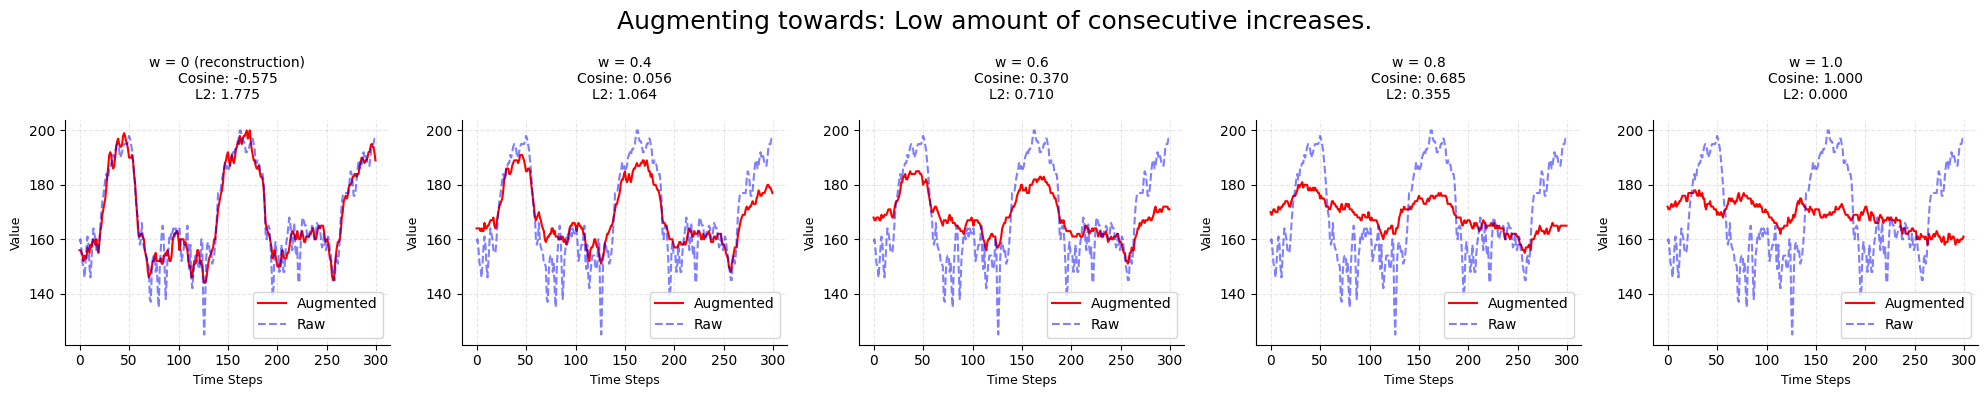

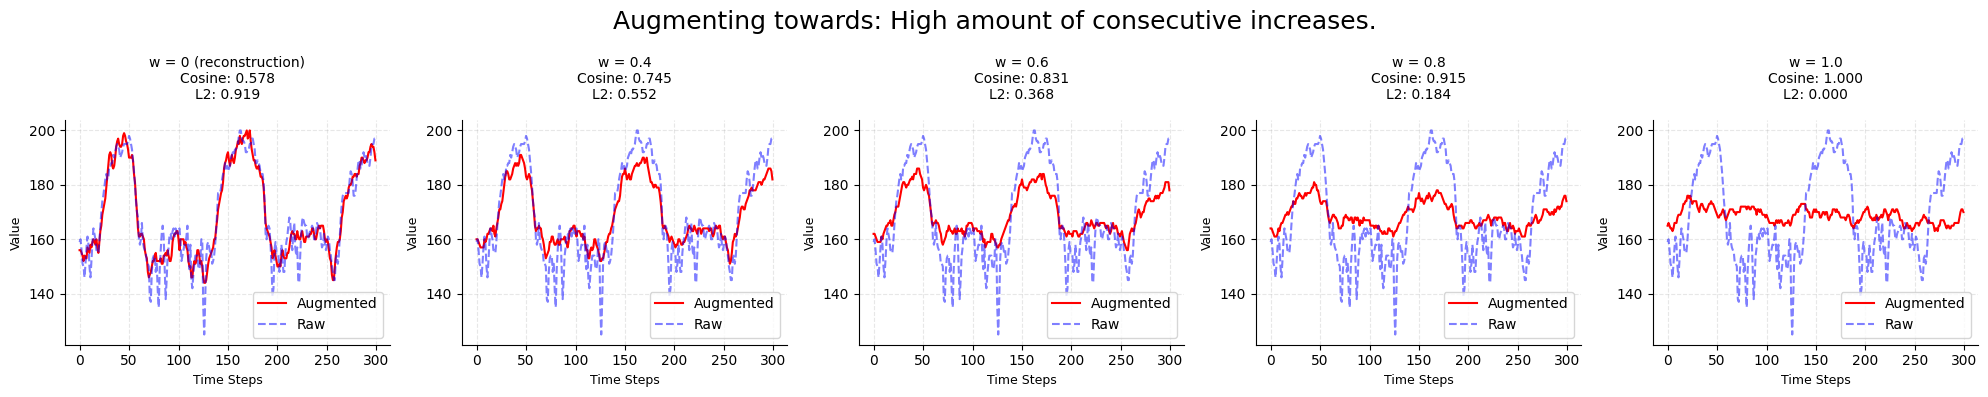

In [7]:
df_train0 = df_train[df_train[config_dict['y_col']] == config_dict['y_levels'][0]].reset_index(drop=True)
df_train1 = df_train[df_train[config_dict['y_col']] == config_dict['y_levels'][1]].reset_index(drop=True)
df_test0 = df_test[df_test[config_dict['y_col']] == config_dict['y_levels'][0]].reset_index(drop=True)
df_test1 = df_test[df_test[config_dict['y_col']] == config_dict['y_levels'][1]].reset_index(drop=True)

tid = 4
df = df_train0.iloc[[tid]].copy()
print(df['text'])
df['text1'] = 'Low amount of consecutive increases.'
df['text2'] = 'High amount of consecutive increases.'

text_cols = ['text1', 'text2']
w_values = np.arange(0.4, 1.2, 0.2)
w_values = np.concatenate([[0], w_values])
plot_interpolate_ts_tx_ws(df, model, config_dict, text_cols, w_values = w_values, label = True)